In [1]:
import torch
import torch.nn as nn
import sent2vec
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
import sent2vec
# Load the pre-trained Sent2Vec model
model_path = "./model/BioSentVec_PubMed_MIMICIII-bigram_d700.bin"
sent_model = sent2vec.Sent2vecModel()
try:
    sent_model.load_model(model_path)
except Exception as e:
    print(e)
print('Model successfully loaded')

Model successfully loaded


In [3]:
import pandas as pd
from scipy.spatial.distance import cosine
# Load the dataset from CSV
test_df = pd.read_csv("./data/biosses_dataset.csv")

# Extract sentences and labels from the dataset
sentences1 = test_df["sentence1"]
sentences2 = test_df["sentence2"]
labels = test_df["score"] / 5  # Normalize the scores to be between 0 and 1

# Pre-embed sentences using Sent2Vec
test_embeddings1 = [sent_model.embed_sentence(str(sentence)).reshape(-1) for sentence in sentences1]
test_embeddings2 = [sent_model.embed_sentence(str(sentence)).reshape(-1) for sentence in sentences2]

predictions0 = [cosine(x,y) for x,y in zip(test_embeddings1, test_embeddings2)]
true_labels = [1 if pred >= 0.5 else 0 for pred in labels]
binary_predictions = [1 if pred >= 0.4 else 0 for pred in predictions0]

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, binary_predictions)
precision = precision_score(true_labels, binary_predictions)
recall = recall_score(true_labels, binary_predictions)
f1 = f1_score(true_labels, binary_predictions)
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.3700
Precision: 0.4066
Recall: 0.8043
F1 Score: 0.5401


In [4]:
# Define neural network model
class SentenceSimilarityModel(nn.Module):
    def __init__(self, input_size):
        super(SentenceSimilarityModel, self).__init__()
        self.fc = nn.Linear(input_size, 1)

    def forward(self, x):
        output = torch.sigmoid(self.fc(x))  # Sigmoid for binary classification
        return output

# Custom dataset for pre-embedded sentences
class EmbeddingDataset(Dataset):
    def __init__(self, sentences1, sentences2, labels):
        self.sentences1 = sentences1
        self.sentences2 = sentences2
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.sentences1[idx], self.sentences2[idx], self.labels[idx]


In [5]:
# Load the dataset from CSV
df = pd.read_csv("./data/biosses_synonym_replacement_augmented.csv")

# Extract sentences and labels from the dataset
sentences1 = df["sentence1"]
sentences2 = df["sentence2"]
labels = df["score"] / 5  # Normalize the scores to be between 0 and 1

# Pre-embed sentences using Sent2Vec
embeddings1 = [sent_model.embed_sentence(str(sentence)) for sentence in sentences1]
embeddings2 = [sent_model.embed_sentence(str(sentence)) for sentence in sentences2]

In [6]:
len(sentences1)

100

In [7]:
# Flatten embeddings and convert to tensors
flatten = lambda t: t.reshape(t.shape[0], -1)  # Define flatten function
embeddings1_tensor = flatten(torch.tensor(embeddings1, dtype=torch.float32))
embeddings2_tensor = flatten(torch.tensor(embeddings2, dtype=torch.float32))
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

/var/folders/1r/f06hrjg92hs7gh5dg5x688jh0000gn/T/ipykernel_3399/2348860910.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  embeddings1_tensor = flatten(torch.tensor(embeddings1, dtype=torch.float32))


In [8]:
accuracy_scores = []
f1_scores = []

In [9]:
for i in range(10, 110, 10):
    # Create the dataset and dataloader
    dataset = EmbeddingDataset(embeddings1_tensor[:i], embeddings2_tensor[:i], labels_tensor[:i])
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Initialize the model
    input_size = embeddings1_tensor.size(1) + embeddings2_tensor.size(1)  # Calculate input size dynamically
    model = SentenceSimilarityModel(input_size=input_size)
    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
    print(f"Training on {i}% of data")
    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        for batch in dataloader:
            optimizer.zero_grad()
            embeddings1_batch, embeddings2_batch, labels_batch = batch
            concatenated_embeddings = torch.cat((embeddings1_batch, embeddings2_batch), dim=1)
            outputs = model(concatenated_embeddings)
            loss = criterion(outputs, labels_batch.unsqueeze(1))  # Ensure labels shape matches outputs
            loss.backward()
            optimizer.step()
        # print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')

    # Load the dataset from CSV
    df = pd.read_csv("./data/biosses_dataset.csv")

    # Extract sentences and labels from the dataset
    sentences1 = df["sentence1"]
    sentences2 = df["sentence2"]
    labels = df["score"] / 5  # Normalize the scores to be between 0 and 1

    # Pre-embed sentences using Sent2Vec
    embeddings1 = [sent_model.embed_sentence(str(sentence)) for sentence in sentences1]
    embeddings2 = [sent_model.embed_sentence(str(sentence)) for sentence in sentences2]

    # Flatten embeddings and convert to tensors
    flatten = lambda t: t.reshape(t.shape[0], -1)  # Define flatten function
    embeddings1_tensor = flatten(torch.tensor(embeddings1, dtype=torch.float32))
    embeddings2_tensor = flatten(torch.tensor(embeddings2, dtype=torch.float32))
    labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

    # Create the dataset and dataloader
    dataset = EmbeddingDataset(embeddings1_tensor, embeddings2_tensor, labels_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Evaluation
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for embeddings1_batch, embeddings2_batch, labels_batch in dataloader:
            concatenated_embeddings = torch.cat((embeddings1_batch, embeddings2_batch), dim=1)
            outputs = model(concatenated_embeddings)
            predictions.extend(outputs.squeeze().tolist())
            true_labels.extend(labels_batch.tolist())



    true_labels = [1 if pred >= 0.5 else 0 for pred in true_labels]

    # Convert predictions to binary (0 or 1) based on threshold
    binary_predictions = [1 if pred >= 0.4 else 0 for pred in predictions]
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, binary_predictions)
    precision = precision_score(true_labels, binary_predictions)
    recall = recall_score(true_labels, binary_predictions)
    f1 = f1_score(true_labels, binary_predictions)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

/Users/jainamshah2718/Desktop/graduate_project/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training on 10% of data
Accuracy: 0.4600
Precision: 0.4600
Recall: 1.0000
F1 Score: 0.6301
Training on 20% of data
Accuracy: 0.5000
Precision: 0.4787
Recall: 0.9783
F1 Score: 0.6429
Training on 30% of data
Accuracy: 0.5000
Precision: 0.4792
Recall: 1.0000
F1 Score: 0.6479
Training on 40% of data
Accuracy: 0.4700
Precision: 0.4646
Recall: 1.0000
F1 Score: 0.6345
Training on 50% of data
Accuracy: 0.5000
Precision: 0.4792
Recall: 1.0000
F1 Score: 0.6479
Training on 60% of data
Accuracy: 0.5100
Precision: 0.4842
Recall: 1.0000
F1 Score: 0.6525
Training on 70% of data
Accuracy: 0.5300
Precision: 0.4946
Recall: 1.0000
F1 Score: 0.6619
Training on 80% of data
Accuracy: 0.5800
Precision: 0.5227
Recall: 1.0000
F1 Score: 0.6866
Training on 90% of data
Accuracy: 0.6000
Precision: 0.5349
Recall: 1.0000
F1 Score: 0.6970
Training on 100% of data
Accuracy: 0.5700
Precision: 0.5169
Recall: 1.0000
F1 Score: 0.6815


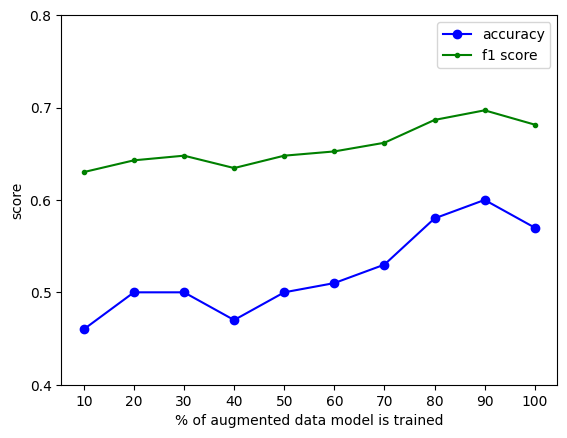

In [10]:
import matplotlib.pyplot as plt
plt.xlabel("%" + " of augmented data model is trained")
plt.ylabel("score")
plt.plot([x for x in range(10, 110, 10)], accuracy_scores, marker='o', color='blue', label='accuracy')  # Plot the chart
plt.plot([x for x in range(10, 110, 10)], f1_scores, marker='.', color='green', label='f1 score')
plt.xticks([x for x in range(10, 110, 10)])
plt.yticks([x/10 for x in range(4, 9, 1)])
plt.legend()
plt.show() 